In [1]:
%matplotlib inline
import prospect

In [2]:
"""
Create and modify Layer objects
"""

from shapely.geometry import Point
import geopandas as gpd
import numpy as np
from scipy.stats import uniform, poisson, norm
from prospect.area import Area

class Layer:

    def __init__(self, area: Area, name: str, features=None, time_penalty: float = 0.0, ideal_obs_rate: float = 1.0):
        self.area_name = area.name
        self.bounds = area.df.total_bounds
        self.name = name
        self.features = features
        self.n_features = features.shape[0]
        self.time_penalty = time_penalty
        self.ideal_obs_rate = ideal_obs_rate

        self.df = gpd.GeoDataFrame({'layer_name': [self.name] * self.n_features,
                                    'fid': [f'{self.name}_{i}' for i in range(self.n_features)],
                                    'time_penalty': [self.time_penalty] * self.n_features,
                                    'ideal_obs_rate': [self.ideal_obs_rate] * self.n_features,
                                    'geometry': self.features},
                                    geometry = 'geometry'
                                    )


    @classmethod
    def from_shapefile(cls, path: str, area: Area, name: str, time_penalty: float = 0.0, ideal_obs_rate: float = 1.0):
        tmp_gdf = gpd.read_file(path)
        return cls(area, name, tmp_gdf['geometry'], time_penalty, ideal_obs_rate)


    @classmethod
    def from_pseudorandom_points(cls, n: int, area: Area, name: str, time_penalty: float = 0.0, ideal_obs_rate: float = 1.0):

        bounds = area.df.total_bounds
        xs = (np.random.random(n) * (bounds[2] - bounds[0])) + bounds[0]
        ys = (np.random.random(n) * (bounds[3] - bounds[1])) + bounds[1]
        points_gds = gpd.GeoSeries([Point(xy) for xy in zip(xs, ys)])

        return cls(area, name, points_gds, time_penalty, ideal_obs_rate)


    @classmethod
    def from_poisson_points(cls, rate: float, area: Area, name: str, time_penalty: float = 0.0, ideal_obs_rate: float = 1.0):
        points = cls.poisson_points(area, rate)
        points_gds = gpd.GeoSeries([Point(xy) for xy in points])
        
        return cls(area, name, points_gds, time_penalty, ideal_obs_rate)


    @classmethod
    def from_thomas_points(cls, parent_rate: float, child_rate: float, gauss_var: float, area: Area, name: str, time_penalty: float = 0.0, ideal_obs_rate: float = 1.0):
        '''
        A Poisson( kappa ) number of parents are created,
        each forming a Poisson( mu ) numbered cluster of points,
        having an isotropic Gaussian distribution with variance `sigma`
        '''
        parents = cls.poisson_points(area, parent_rate)
        M = parents.shape[0]

        points = list()    
        for i in range(M):
            N = poisson(child_rate).rvs()
            for __ in range(N):            
                pdf = norm(loc=parents[i,:2], scale=(gauss_var,gauss_var))
                points.append(list(pdf.rvs(2)))
        points = np.array(points)
        points_gds = gpd.GeoSeries([Point(xy) for xy in points])

        return cls(area, name, points_gds, time_penalty, ideal_obs_rate)


    @classmethod
    def from_matern_points(cls, parent_rate: float, child_rate: float, radius: float, area: Area, name: str, time_penalty: float = 0.0, ideal_obs_rate: float = 1.0):
        parents = cls.poisson_points(area, parent_rate)
        M = parents.shape[0]
        
        points = list()
        for i in range(M):
            N = poisson(child_rate).rvs()
            for __ in range(N):
                x, y = cls.uniform_disk(parents[i,0], parents[i,1], radius)
                points.append([x, y])
        points = np.array(points)
        points_gds = gpd.GeoSeries([Point(xy) for xy in points])

        return cls(area, name, points_gds, time_penalty, ideal_obs_rate)


    @staticmethod
    def poisson_points(area: Area, rate: float):

        bounds = area.df.total_bounds        
        dx = bounds[2] - bounds[0]
        dy = bounds[3] - bounds[1]

        N = poisson(rate * dx * dy ).rvs()
        xs = uniform.rvs(0, dx, ((N,1)))
        ys = uniform.rvs(0, dy, ((N,1)))
        return np.hstack((xs, ys))


    @staticmethod
    def uniform_disk(x, y, r):
        '''
        Returns a uniformly distributed point in a
        disk of radius `r` centered at the point (x,y).
        '''
        r = uniform(0, r**2.0).rvs()
        theta = uniform(0, 2*np.pi).rvs()
        xt = np.sqrt(r) * np.cos(theta)
        yt = np.sqrt(r) * np.sin(theta)
        return x+xt, y+yt


    @classmethod
    def make_polygons(cls):
        pass


In [31]:
a = prospect.Area.from_area_value('area_test', 1)

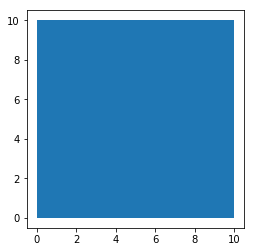

In [28]:
a.df.plot()

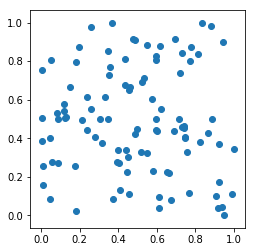

In [49]:
pseudo = Layer.from_pseudorandom_points(100, area=a, name='pseudoLayer')
pseudo.df.plot();

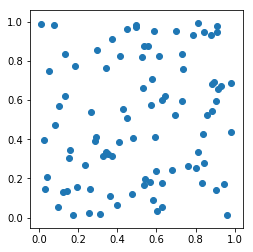

In [50]:
pp = Layer.from_poisson_points(100, a, 'poissonLayer')
pp.df.plot();

In [70]:
import numpy as np
n_pts = []
for i in range(100000):
    pp = Layer.from_poisson_points(5.0, a, 'loop')
    n_pts.append(pp.df.shape[0])

In [71]:
print(np.mean(n_pts))

5.00729


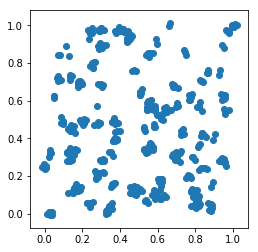

In [53]:
thomas = Layer.from_thomas_points(100.0, 5.0, 0.01, area= a, name='thomasLayer')
thomas.df.plot();

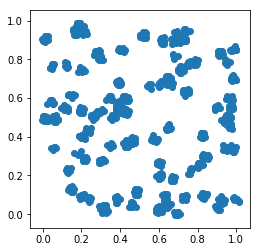

In [61]:
matern = Layer.from_matern_points(100.0, 10.0, 0.02, area=a, name='maternLayer')
matern.df.plot();